# Advanced Techniques

DeerLab is capable of much more than what we showed the presentation. Here are three step by step examples for some commonly used advanced features. After you have looked through 1 and 2 you can do Exercise 2 on the sheet. 

- Custom Dipolar Modelling
- Compactness Criterion
- Global Fitting

In [21]:
import deerlab as dl
# We all need some other packages too
import numpy as np # Numerical calculations and array handling
import matplotlib.pyplot as plt # Plotting

## Custom Dipolar Modeling

So far we have looked at fitting using a non-paramateric model free approach. DeerLab is also capable at model based fitting. 

Some possible models are:
- Gaussian (one, two, three)
- Rice (one, two, three)
- Wormchain (for rigid rulers)
- 3D models

In [27]:
t,V = dl.deerload('data/example_4pdeer_4.DTA')
Vexp = dl.correctphase(V)
Vexp = Vexp/np.max(Vexp)

tau1 = 0.5 # µs
tau2 = 5.0 # µs
tmin = 0.3 # µs

t = t - t[0]  # Subtracting first value in array
t = t + tmin
r = np.linspace(2,5,100)  # nm 


In [28]:
Pmodel = dl.dd_gauss
Vmodel = dl.dipolarmodel(t,r,Pmodel, experiment=dl.ex_4pdeer(tau1,tau2, pathways=[1]))
results = dl.fit(Vmodel,Vexp,reg=False)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.982             0.048          0.002  
========= ============= ============= ===================== ======= 
Model parameters: 
=========== ========= ========================= ====== ============================== 
 Parameter   Value     95%-Confidence interval   Unit   Description                   
=========== ========= ========================= ====== ============================== 
 mod         0.200     (0.200,0.201)                    Modulation depth              
 reftime     0.499     (0.497,0.501)              μs    Refocusing time               
 conc        119.117   (118.004,120.229)          μM    Spin concentration            
 mean        4.200     (4.196,4.205)              nm    Mean                          
 std     

In [29]:
# Extract fitted dipolar signal
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.evaluate(Pmodel,r)
scale = np.trapz(Pfit,r)
Puncert = results.propagate(Pmodel,r,lb=np.zeros_like(r))
Pfit = Pfit/scale
Pci95 = Puncert.ci(95)/scale
Pci50 = Puncert.ci(50)/scale

In [30]:
# Extract the unmodulated contribution
Bfcn = lambda mod,conc,reftime: scale*(1-mod)*dl.bg_hom3d(t-reftime,conc,mod)
Bfit = results.evaluate(Bfcn)
Bci = results.propagate(Bfcn).ci(95)

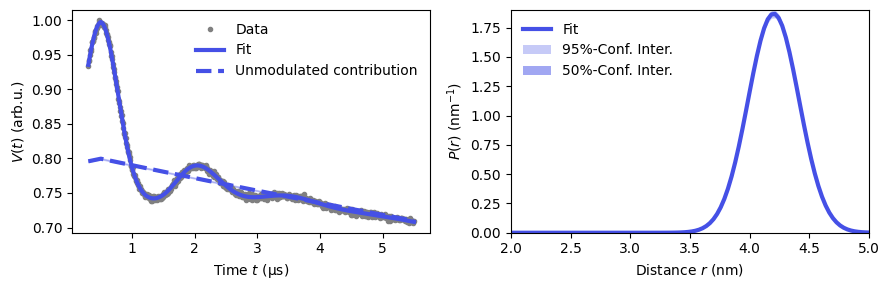

In [31]:
plt.figure(figsize=[9,3])
violet = '#4550e6'
plt.subplot(1,2,1)
# Plot experimental and fitted data
plt.plot(t,Vexp,'.',color='grey',label='Data')
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(1,2,2)
plt.plot(r,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Compactness Criterion

It is often the case that there is a non-unique solution for the speration of the background. This is especially tue for noisy data and dataset where the trace is not long enough.

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/2746d801bdf97b7afd75d4f666d8fd414af490d8/images/example_identiability.svg" style="width:700px">

DeerLab has a compactness penalty introduced in the regularization. This has the effect of adding an aditional penalty to the objective function than penalizes non-compact data. 

For nearly all applications it is recomended that the compactness criterion is used.

In [33]:
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1])

Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 
compactness = dl.dipolarpenalty(Pmodel=None, r=r, type='compactness')
results = dl.fit(Vmodel,Vexp,penalties=compactness)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.999             0.023          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.146                   0.056        
========================== =================== 
Model parameters: 
=========== ========= ========================= ====== ====================================== 
 Parameter   Value     95%-Confidence interval   Unit   Description                           
=========== ========= ========================= ====== ====================================== 
 mod         0.200     (0.200,0.201)                    Modulation de

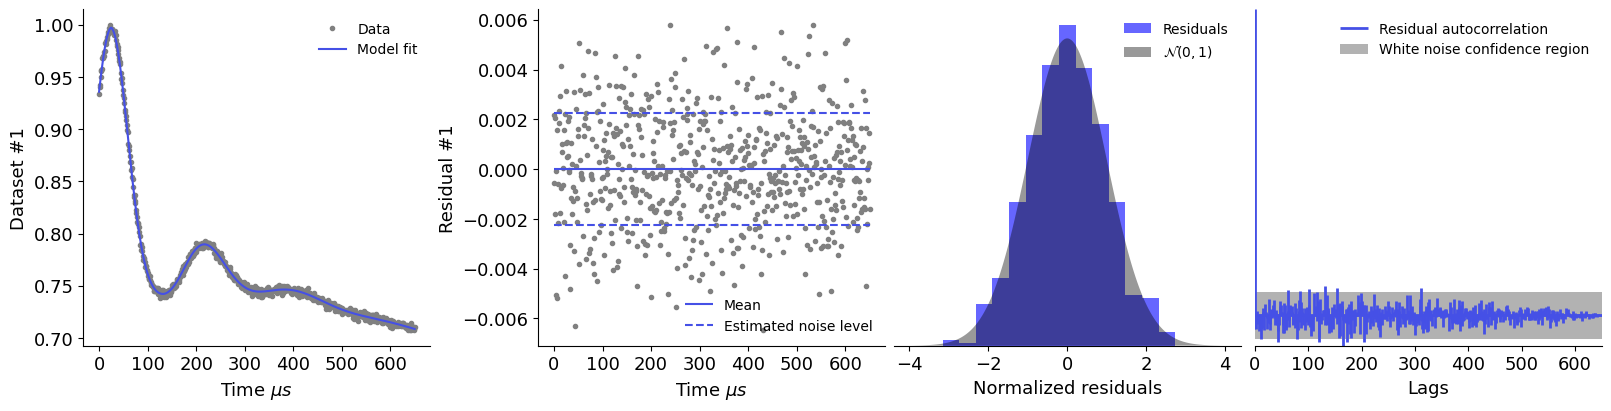

In [34]:
results.plot(gof=True, xlabel='Time $\mu s$');

## Global Fitting

Often you end up with multiple measurments of the same sample. Instead of fitting these traces independently we will fit them all as one, globally.

Here we will use a non parametric fit and the defauly homogenous background model

In this example I am going to ask you to attempt it mostly by yourselves first

In [40]:
# File location
path = 'data/'
file4p = 'example_4pdeer_2.DTA'
file5p = 'example_5pdeer_2.DTA'

# Experimental parameters (4pDEER)
tau1_4p = 0.5               # First int er-pulse delay, μs
tau2_4p = 3.5               # Second inter-pulse delay, μs
deadtime_4p = 0.1           # Acquisition deadtime, μs

# Experimental parameters (reversed 5pDEER)
tau1_5p = 2.9               # First inter-pulse delay, μs
tau2_5p = 3.3               # Second inter-pulse delay, μs
tau3_5p = 0.3               # Third inter-pulse delay, μs
deadtime_5p = 0.1           # Acquisition deadtime, μs

In [41]:
# Load the experimental data (4pDEER)
t4p,V4p = dl.deerload(path + file4p)
V4p = dl.correctphase(V4p)    # Phase correction
V4p = V4p/np.max(V4p)         # Rescaling (aesthetic)
t4p = t4p + deadtime_4p       # Account for deadtime
# Load the experimental data (reversed 5pDEER)
t5p,V5p = dl.deerload(path + file5p)
V5p = dl.correctphase(V5p)    # Phase correction
V5p = V5p/np.max(V5p)         # Rescaling (aesthetic)
t5p = t5p + deadtime_5p       # Account for deadtime

In [42]:
# Load the experimental data (4pDEER)
t4p,V4p = dl.deerload(path + file4p)
V4p = dl.correctphase(V4p)    # Phase correction
V4p = V4p/np.max(V4p)         # Rescaling (aesthetic)
t4p = t4p + deadtime_4p       # Account for deadtime
# Load the experimental data (reversed 5pDEER)
t5p,V5p = dl.deerload(path + file5p)
V5p = dl.correctphase(V5p)    # Phase correction
V5p = V5p/np.max(V5p)         # Rescaling (aesthetic)
t5p = t5p + deadtime_5p       # Account for deadtime

In [43]:
# Run fit
r = np.arange(2.5,6,0.05)

# Construct the individual dipolar signal models
V4pmodel = dl.dipolarmodel(t4p,r,experiment=dl.ex_4pdeer(tau1=tau1_4p,tau2=tau2_4p,pathways=[1,2,3]))
V5pmodel = dl.dipolarmodel(t5p,r,experiment=dl.ex_rev5pdeer(tau1=tau1_5p,tau2=tau2_5p,tau3=tau3_5p,pathways=[1,2]))

# Make the joint model with the distribution as a global parameters
globalmodel = dl.merge(V4pmodel,V5pmodel,addweights=True)
globalmodel = dl.link(globalmodel, P = ['P_1','P_2'])

In [44]:
# Fit the model to the data (with fixed regularization parameter)
results = dl.fit(globalmodel,[V4p,V5p], weights=[1,1])

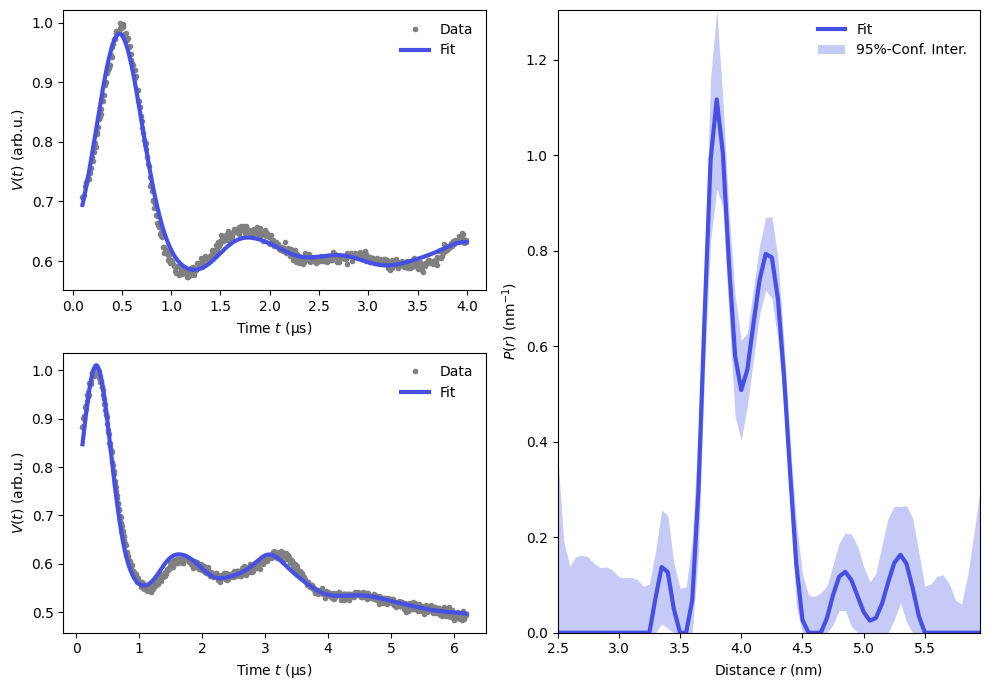

In [45]:
plt.figure(figsize=[10,7])
violet = '#4550e6'

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)
for n,(t,V) in enumerate(zip([t4p,t5p],[V4p,V5p])):

    # Extract fitted dipolar signal
    Vfit = results.model[n]

    plt.subplot(2,2,1+n*2)
    # Plot experimental data
    plt.plot(t,V,'.',color='grey',label='Data')
    # Plot the fitted signal
    plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
    plt.legend(frameon=False,loc='best')
    plt.xlabel('Time $t$ (μs)')
    plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(1,2,2)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()